In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
market_cap = pd.read_excel('Group_G copy.xlsx', sheet_name=1)
price_index = pd.read_excel('Group_G copy.xlsx', sheet_name=2, index_col='Date')
revenue = pd.read_excel('Group_G copy.xlsx', sheet_name=3)
emission = pd.read_excel('Group_G copy.xlsx', sheet_name=4)

In [3]:
def assets_returns(assets, period, compounded=True):
    if not compounded:
        asset_return = (assets / assets.shift(periods=period)) - 1
    elif compounded:
        diff = assets / assets.shift(periods=period)
        asset_return = np.log(diff.astype('float'))
    return asset_return

In [4]:
simple_return = assets_returns(price_index, period=1, compounded=False)
simple_return

,CAMPBELL SOUP - TOT RETURN IND (~U$) (#T) - CAMPBELL SOUP - TOT RETURN IND (~U$) (#T),ZOETIS A - TOT RETURN IND (~U$) (#T) - ZOETIS A - TOT RETURN IND (~U$) (#T),APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T) - APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T),WILLIAMS - TOT RETURN IND (~U$) (#T) - WILLIAMS - TOT RETURN IND (~U$) (#T),TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T) - TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T),BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T) - BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T),NASDAQ - TOT RETURN IND (~U$) (#T) - NASDAQ - TOT RETURN IND (~U$) (#T),ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T) - ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T),XEROX HOLDINGS - TOT RETURN IND (~U$) (#T) - XEROX HOLDINGS - TOT RETURN IND (~U$) (#T),UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T) - UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T),...,WSP GLOBAL - TOT RETURN IND (~U$) (#T) - WSP GLOBAL - TOT RETURN IND (~U$) (#T),CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T) - CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T),SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T) - SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T),FORTIS - TOT RETURN IND (~U$) (#T) - FORTIS - TOT RETURN IND (~U$) (#T),FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T) - FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T),CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T) - CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T),ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T) - ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T),ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T) - ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T),BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T) - BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T),SUPERIOR PLUS - TOT RETURN IND (~U$) (#T) - SUPERIOR PLUS - TOT RETURN IND (~U$) (#T)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-04,-0.019318,NaN,0.015101,-0.032066,0.030542,NaN,NaN,-0.003204,-0.002122,0.016873,...,NaN,NaN,-0.002606,-0.004760,0.016243,-0.043171,-0.047274,0.084056,NaN,0.013898
1999-01-05,0.026652,NaN,-0.001637,-0.010350,-0.020790,NaN,NaN,0.000000,0.019105,0.004731,...,NaN,NaN,0.020889,0.013321,0.009300,-0.004439,0.039058,0.038704,NaN,0.002721
1999-01-06,-0.009481,NaN,0.004955,0.031381,-0.002646,NaN,NaN,-0.003216,0.019268,-0.001175,...,NaN,NaN,0.020459,0.017944,0.018716,-0.008832,0.051234,0.052293,NaN,0.014192
1999-01-07,-0.013731,NaN,-0.023092,0.000000,-0.005047,NaN,NaN,-0.022581,-0.004591,-0.028336,...,NaN,NaN,-0.047619,0.021613,0.042114,-0.037937,-0.022692,-0.007082,NaN,-0.001749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-12-27,0.004714,-0.003159,-0.027325,0.002701,0.006491,-0.010185,-0.004892,NaN,0.006185,0.003552,...,0.006489,0.016272,0.006834,0.006489,0.006490,-0.012793,-0.017874,0.005845,0.006487,0.006487
2022-12-28,-0.008863,-0.010126,-0.015446,-0.020653,-0.011865,-0.034947,-0.004595,NaN,-0.022539,-0.013380,...,-0.013214,-0.067686,-0.005703,-0.015304,-0.034375,-0.003477,-0.018401,-0.013700,-0.051007,-0.004856


In [5]:
log_return = assets_returns(price_index, period=1, compounded=True)
log_return

/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,CAMPBELL SOUP - TOT RETURN IND (~U$) (#T) - CAMPBELL SOUP - TOT RETURN IND (~U$) (#T),ZOETIS A - TOT RETURN IND (~U$) (#T) - ZOETIS A - TOT RETURN IND (~U$) (#T),APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T) - APARTMENT INV.& MAN.'A' - TOT RETURN IND (~U$) (#T),WILLIAMS - TOT RETURN IND (~U$) (#T) - WILLIAMS - TOT RETURN IND (~U$) (#T),TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T) - TNSC.'A' SBVTG. - TOT RETURN IND (~U$) (#T),BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T) - BREAD FINANCIAL HOLDINGS - TOT RETURN IND (~U$) (#T),NASDAQ - TOT RETURN IND (~U$) (#T) - NASDAQ - TOT RETURN IND (~U$) (#T),ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T) - ENERGEN DEAD - DELIST.30/11/18 - TOT RETURN IND (~U$) (#T),XEROX HOLDINGS - TOT RETURN IND (~U$) (#T) - XEROX HOLDINGS - TOT RETURN IND (~U$) (#T),UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T) - UNIVERSAL HEALTH SVS.'B' - TOT RETURN IND (~U$) (#T),...,WSP GLOBAL - TOT RETURN IND (~U$) (#T) - WSP GLOBAL - TOT RETURN IND (~U$) (#T),CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T) - CHIMERA INVESTMENT - TOT RETURN IND (~U$) (#T),SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T) - SYNOVUS FINANCIAL - TOT RETURN IND (~U$) (#T),FORTIS - TOT RETURN IND (~U$) (#T) - FORTIS - TOT RETURN IND (~U$) (#T),FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T) - FREEHOLD ROYALTIES - TOT RETURN IND (~U$) (#T),CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T) - CHEESECAKE FACTORY - TOT RETURN IND (~U$) (#T),ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T) - ROYAL CARIBBEAN GROUP - TOT RETURN IND (~U$) (#T),ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T) - ENTERPRISE PRDS.PTNS.LP. - TOT RETURN IND (~U$) (#T),BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T) - BIRCHCLIFF ENERGY - TOT RETURN IND (~U$) (#T),SUPERIOR PLUS - TOT RETURN IND (~U$) (#T) - SUPERIOR PLUS - TOT RETURN IND (~U$) (#T)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-04,-0.019507,NaN,0.014988,-0.032592,0.030085,NaN,NaN,-0.003209,-0.002124,0.016733,...,NaN,NaN,-0.002609,-0.004772,0.016113,-0.044131,-0.048428,0.080710,NaN,0.013802
1999-01-05,0.026303,NaN,-0.001638,-0.010404,-0.021009,NaN,NaN,0.000000,0.018925,0.004720,...,NaN,NaN,0.020673,0.013233,0.009257,-0.004449,0.038315,0.037974,NaN,0.002717
1999-01-06,-0.009527,NaN,0.004943,0.030899,-0.002649,NaN,NaN,-0.003222,0.019085,-0.001176,...,NaN,NaN,0.020253,0.017785,0.018543,-0.008872,0.049965,0.050971,NaN,0.014092
1999-01-07,-0.013826,NaN,-0.023363,0.000000,-0.005060,NaN,NaN,-0.022839,-0.004602,-0.028745,...,NaN,NaN,-0.048790,0.021383,0.041252,-0.038676,-0.022953,-0.007107,NaN,-0.001751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-12-27,0.004703,-0.003164,-0.027706,0.002697,0.006470,-0.010237,-0.004904,NaN,0.006166,0.003546,...,0.006468,0.016141,0.006811,0.006468,0.006469,-0.012875,-0.018035,0.005828,0.006466,0.006466
2022-12-28,-0.008902,-0.010177,-0.015566,-0.020870,-0.011936,-0.035572,-0.004606,NaN,-0.022797,-0.013470,...,-0.013302,-0.070085,-0.005719,-0.015422,-0.034980,-0.003483,-0.018572,-0.013795,-0.052354,-0.004868


In [6]:
def get_moment(assetReturn, moment):
    if moment == 1:
        return pd.DataFrame(assetReturn.mean())
    elif moment == 2:
        return pd.DataFrame(assetReturn.std())
    elif moment == 3:
        return pd.DataFrame(assetReturn.skew())
    elif moment == 4:
        nu = (pow(assetReturn, moment)).mean() - pow(assetReturn.mean(), moment)
        den = pow(assetReturn.std(), moment)
        res = nu / den
        return pd.DataFrame(res)

In [7]:
simple_mean = get_moment(simple_return, 1)
simple_std = get_moment(simple_return, 2)
simple_skew = get_moment(simple_return, 3)
simple_kurt = get_moment(simple_return, 4)

In [8]:
def jarque_bera(series, skewness, kurtosis):
    t = np.shape(series)[0]
    tstat = t * (pow(skewness, 2)/6 + pow((kurtosis), 2)/24)
    return tstat

In [9]:
jb_res = jarque_bera(simple_return, simple_skew, simple_kurt)

In [10]:
def jb_test(tstat, alpha, dof):
    critical_val = stats.chi2.ppf(1-alpha, df=dof)
    out = {}
    for k, v in tstat.T.items():
        if v[0] >= critical_val:

            # print(f'Reject H0: Return is not Gaussian')
            out[k] = 'Reject H0: Return is not Gaussian'
    return pd.Series(out)

In [11]:
test_res = jb_test(jb_res, 0.05, 2)

In [12]:
def get_acf(ds: pd.DataFrame, nlags=10) -> pd.DataFrame:
    out = {}
    for k in ds.keys():
        res = sm.tsa.acf(ds[k], nlags=nlags, missing='conservative')
        out[k] = res[1:]
    return pd.DataFrame(out)

In [13]:
acf = get_acf(simple_return, nlags=10)
squared_acf = get_acf(pow(simple_return, 2), nlags=10)

/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:463: RuntimeWarning: invalid value encountered in double_scalars
  xo = x - x.sum() / notmask_int.sum()
/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:518: RuntimeWarning: invalid value encountered in true_divide
  acov = np.fft.ifft(Frf * np.conjugate(Frf))[:nobs] / d[nobs - 1 :]
/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:463: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.sum() / notmask_int.sum()


In [14]:
def ljung_box(acf, returns, nlag):
    t = np.shape(returns)[0]
    tstat = t*(t+2)*1/(t-nlag)*pow(acf.iloc[nlag],2)
    return tstat


lj_stat = {}
for i in range(10):
    lj_stat[i] = ljung_box(acf, simple_return, i)
lj_stat = pd.DataFrame(lj_stat).transpose()

In [15]:
# Filtered portfolio inputs
opt_simple = simple_return.dropna(thresh=145).dropna(axis=1)
opt_mean = get_moment(opt_simple, 1)
opt_vol = get_moment(opt_simple, 2)
opt_skew = get_moment(opt_simple, 3)
opt_kurt = get_moment(opt_simple, 4)


# For annualized portfolio inputs
annual_mean = pow((1+opt_mean), 252) -1
annual_vol = opt_vol * np.sqrt(252)

In [16]:
def get_weight(num_assets, size):
    weights = np.random.randn(num_assets, size)
    weights = pd.DataFrame(weights)
    for i in range(size):
        weights.iloc[:, i] = weights.iloc[:, i] / weights.iloc[:, i].sum()
    return weights


# On the rows are each asset's weight in different portfolios,
# columns are asset allocation of each portfolio
random_weight = get_weight(np.shape(opt_simple)[1], 1000 )

In [17]:
def portfolio_return(asset_returns, port_weight):
    if np.shape(asset_returns)[1] != np.shape(port_weight)[0]:
        port_mean = asset_returns.T.values @ port_weight.values
    else:
        port_mean = asset_returns.values @ port_weight.values
    port_mean = pd.DataFrame(port_mean).transpose()
    port_mean.index = port_weight.T.index
    port_mean.columns = ['Portfolio Mean']
    return port_mean


def vcv_matrix(asset_returns):
    return asset_returns.cov()


def portfolio_var(port_weight, vcv):
    out = {}
    for i in port_weight:
        out[i] = port_weight.iloc[:, i].values.T @ vcv.values @ port_weight.iloc[:, i].values
    out = pd.Series(out)
    out.name = 'Sigma'
    return out

In [18]:
opt_mu = portfolio_return(opt_mean, random_weight)
opt_vcv = vcv_matrix(opt_simple)
opt_sigma2 = portfolio_var(random_weight, opt_vcv)
opt_sigma = np.sqrt(opt_sigma2)
annual_opt_mu = pow((1+opt_mu), 252) -1
annual_opt_vol = opt_sigma * np.sqrt(252)

0.24751988335462122

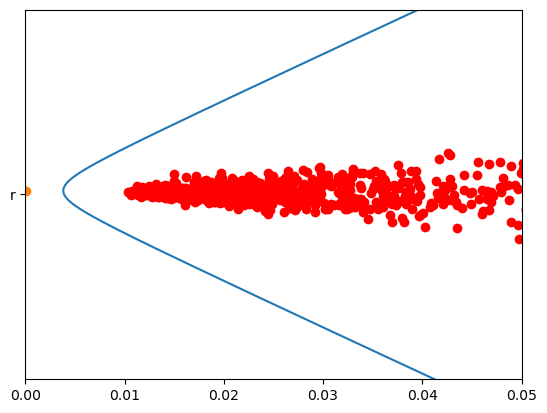

In [39]:
mu = opt_simple.mean().values
cov = opt_simple.cov().values

A = np.ones(145).T @ np.linalg.inv(cov) @ mu
B = mu.T @ np.linalg.inv(cov) @ mu
C = np.ones(145).T @ np.linalg.inv(cov) @ np.ones(145)
D = B * C - pow(A, 2)

# global minimum variance portfolio
gmvp = (np.linalg.inv(cov) @ np.ones(145)) / C
gmvp_mu = A/C
sigma = 1/C
min_weight = 1 - np.ones(145) @ np.linalg.inv(cov) @ mu
minport = np.linalg.inv(cov) @ np.ones(145) / (np.ones(145).T @ np.linalg.inv(cov) @ np.ones(145))

# speculative portfolio
spec = (np.linalg.inv(cov) @ mu) / (np.ones(145) @ np.linalg.inv(cov) @ mu)
spec_weight = np.ones(145) @ np.linalg.inv(cov) @ mu

# optimal portfolio
opt_portfolio = min_weight * minport + spec_weight * spec
optimal_mu = opt_portfolio @ mu
optimal_variance = opt_portfolio.T @ cov @ opt_portfolio

x = np.linspace(-0.2, 0.3, 10000)
y = np.sqrt(C/D * pow(x - A/C, 2) + 1/C)

ax = plt.gca()
ax.plot(y.T, x)
ax.plot(sigma, gmvp_mu, 'o')

ran_mu = random_weight.T @ mu
ran_sigma = portfolio_var(random_weight, opt_simple.cov())
ax.plot(np.sqrt(ran_sigma), ran_mu, 'ro')
ax.plot(optimal_variance, optimal_mu, 'o', 'r')

ax.set_ylim(-0.02, 0.02)
ax.set_xlim(0, 0.05)
optimal_mu

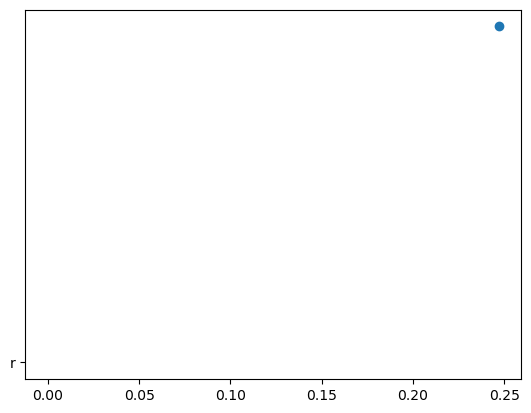

In [37]:
ax = plt.gca()
ax.plot(optimal_variance, optimal_mu, 'o', 'r')
ax.plot()

In [40]:
def efficient_frontier(mean, vcv, num_port):
    """

    :param mean: All asset's expected return
    :param vcv: The variance covariance matrix
    :param num_port: Number of equally spaced return portfolios
    :return: This function returns only the combination of optimized portfolio mean and portfolio variances
    """
    A = mean.T @ np.linalg.inv(vcv) @ mean
    B = mean.T @ np.linalg.inv(vcv) @ np.ones(np.shape(mean)[0])
    C = np.ones(np.shape(mean)[0]).T @ np.linalg.inv(vcv) @ np.ones(np.shape(mean)[0])

    mu = np.linspace(-0.1, 0.25, num_port)
    std = ((C * pow(mu, 2) - 2*B*mu + A)/(A*C-pow(B, 2))).T.reshape(-1)
    out = pd.DataFrame({'mu_p': mu, 'mu_std': std})

    mvp_weight = np.linalg.inv(vcv) @ np.ones(np.shape(mean)[0]) / C
    mvp_return = mvp_weight.T @ mean
    mvp_vcv = mvp_weight.T @ vcv @ mvp_weight

    return [out, mvp_weight, mvp_return, mvp_vcv]

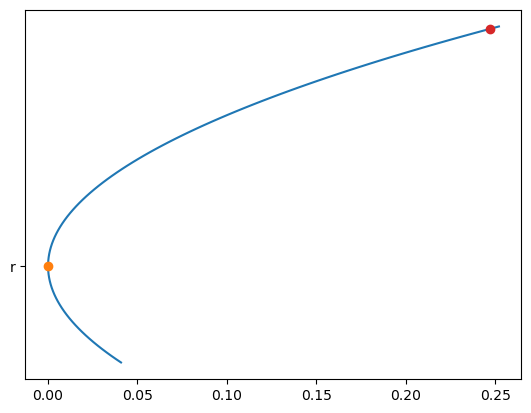

In [41]:
f = efficient_frontier(opt_mean.values, opt_vcv, 100)
ax = plt.gca()
ax.plot(f[0]['mu_std'], f[0]['mu_p'])
mvp_weight = f[1]
mvp_retr = f[2]
mvp_vcv2 = f[3]
ax.plot(mvp_vcv2, mvp_retr, 'o', 'r')
ax.plot(optimal_variance, optimal_mu, 'o', 'r')

In [22]:
# Efficient frontier using optimization method
def min_variance_portfolio(vcv, initial_weight, risk_free: float):
    """

    :param vcv: The variance covariance matrix
    :param initial_weight: Initial guess of asset weight allocation
    :param risk_free:
    :return: Optimal weight allocation of assets given the covariance matrix
    """
    if not risk_free:
        obj = lambda a: a.T @ vcv.values @ a
        cons = {
            'type': 'eq',
            'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
        }
        bnds = [[None, None] for i in range(len(initial_weight))]
        port_weight = minimize(obj, x0=initial_weight, constraints=cons, bounds=bnds)
        return port_weight

In [23]:
f

[        mu_p    mu_std
 0  -0.100000  0.040812
 1  -0.097980  0.039187
 2  -0.095960  0.037595
 3  -0.093939  0.036036
 4  -0.091919  0.034510
 ..       ...       ...
 95  0.091919  0.033904
 96  0.093939  0.035416
 97  0.095960  0.036962
 98  0.097980  0.038541
 99  0.100000  0.040153
 
 [100 rows x 2 columns],
 array([ 4.49996680e-02,  4.52575977e-03, -2.06895775e-02, -2.72071193e-02,
         8.85003044e-03,  2.07493197e-02,  4.75843708e-03,  1.78733695e-02,
        -1.33887022e-02, -2.06073421e-02, -3.89395525e-02,  1.98768318e-03,
         4.16455211e-02,  2.37064433e-03,  4.46455425e-03, -6.94965731e-02,
         6.65627058e-03, -3.29175614e-02,  1.05316720e-02,  4.87526440e-02,
         7.61406288e-03, -1.58742772e-02, -1.12852971e-01,  2.17240921e-02,
        -4.75755636e-02,  1.05491553e-02,  3.53822835e-02,  5.32728753e-02,
        -2.64026424e-02, -3.24785924e-03,  1.03994870e-02, -8.13727201e-02,
        -6.05032378e-02, -3.92911787e-02,  1.05852543e-02, -4.35524845e-03,
 

TypeError: list indices must be integers or slices, not str

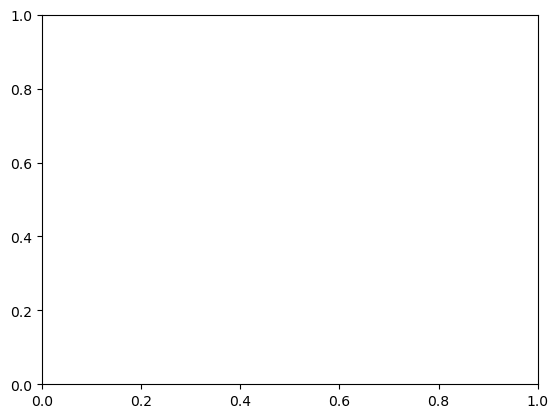

In [24]:
ax = plt.gca()
y2 = np.sqrt(f['mu_std']) # this is actually the squared root of the variance


pmus = []
pvols = []
# for i in range(len(random_weight.columns)):
#     res = ef_optimization(opt_vcv, random_weight.iloc[:, i], risk_free=False)
#
#     pmu = res.x @ opt_mean
#     pvol = res.x.T @ opt_vcv @ res.x
#     pmus.append(pmu)
#     pvols.append(pvol)
#     ax.plot(np.sqrt(pvol).T, pmu, 'ro')
#
# # ax.set_ylim(-0.01, 0.02)
# # ax.set_xlim(0, 0.05)
# ax.plot(y2, f['mu_p'])

In [ ]:
ax = plt.gca()
ax.plot(pvols, pmus, 'ro')
ax.plot(y2, f['mu_p'])
ax.set_xlim(0, 0.01)
ax.set_ylim(-0.05, 0.05)

In [ ]:
def portfolio_resampling(row_selected, num_iter, len_dummy_mu):
    """

    :param row_selected: Number of draws of raw returns we have for each sample
    :param num_iter: Number of resampled returns
    :param len_dummy_mu: Number of portfolio returns we set to optimize for portfolio volatility
    :return: The output contains multiple outputs. First, the optimal allocation given all returns, the expected return of the portfolio, the variacne of the optimal portfolios.
    """
    out = []
    optimal_weights = []
    optimal_mu = []
    optimal_vcv = []
    for i in range(num_iter):
        sam = opt_simple.sample(n=row_selected, ignore_index=True)
        mu = sam.mean()
        optimal_mu.append(mu)
        cov = sam.cov()
        optimal_vcv.append(cov)
        res = efficient_frontier(mu, cov, len_dummy_mu)
        num = np.linalg.inv(cov) @ np.ones(np.shape(cov)[0])
        den = np.ones(np.shape(cov)[0]).T @ np.linalg.inv(cov) @ np.ones(np.shape(cov)[0])
        alpha = num / den
        out.append(res['mu_std'])
        optimal_weights.append(alpha)
    df = pd.DataFrame(np.asarray(out).T, index=res['mu_p'])
    optimal_weights = pd.DataFrame(optimal_weights).T
    optimal_mu = pd.DataFrame(optimal_mu)
    return [df, optimal_weights, optimal_mu]


# def resampled_mu(row_selected, num_iter, )

In [ ]:
resampled = portfolio_resampling(300, 2000, 200)
# resampled = pd.DataFrame(np.asarray(resampled).T)
# np.shape(resampled)
# all_weights = []


# for i in range(np.shape(resampled)[0]+1):
#     resampled.iloc[:, i] = resampled.iloc[:, i] / resampled.iloc[:, i].sum()


# all_weights = pd.DataFrame(all_weights)
# all_weights.sum()
# resampled.plot(legend=False)
resampled[1].sum()

In [ ]:
final_sample = resampled.mean(axis=1)
final_sample
final_sample

In [ ]:
ax = plt.gca()
for i in range(len(resampled.columns)):
    ax.plot(resampled.iloc[:, i], resampled.index, 'k-', lw=0.05)
ax.plot(resampled.mean(axis=1), resampled.index, 'r-', lw=1.2)

In [ ]:
emission

In [ ]:
for i in emission.columns:
    print(type(i))

In [ ]:
revenue

In [ ]:
carbon_intensity = []
for i in emission.columns:
    res = emission.iloc[:, i].values / emission[:, i]
    carbon_intensity.append(res)


In [ ]:
emission.iloc[:, 1].values

In [ ]:
out = []
for i, a in emission.iloc[:, 1].values, revenue.iloc[:, 1]:
    res = i/a
    out.append(res)

out = pd.DataFrame(out)

In [ ]:
revenue

In [ ]:
revenue.iloc[:, 1].values